# Data Report: Correlation of share of electric vehicles among all registrations and GDP

Author: Lucca Baumgärtner  

This report uses open data from Mobilithek (https://mobilithek.info/offers/573357280039153664) containing information about vehicle registrations (VR) in Germany (provided by the "Kraftfahrtbundesamt") and combines with data from the "Statistikportal" (https://www.statistikportal.de/de/veroeffentlichungen/bruttoinlandsprodukt-bruttowertschoepfung) providing information about the GDP of all german federal states.  

The question that interests us is: Does a correlation between the share of EVs among all registrations and the GDP exist?

## Install dependencies
Initially, install all required dependencies, which are listed in the file `requirements.txt`.

In [11]:
%%capture
%pip install -r ../requirements.txt

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import calendar
import json

## Load data
Create a pandas dataframe using the local sqlite file.

In [13]:
# the full dataframe contains uncompressed information for every month and every state
full_df = pd.read_sql_table('vr_2023', 'sqlite:///../data/clean/evs_per_capita.sqlite')
first_month = int(full_df['month'].min())
last_month = int(full_df['month'].max())
year = int(full_df['year'].max())

# the aggregated dataframe combines all monthly data
aggr_df = pd.read_sql_table('evs_per_capita', 'sqlite:///../data/clean/evs_per_capita.sqlite')

## How are vehicle registrations developing?

In [14]:
#vr_state_month_df = full_df.groupby(['federal_state', 'month']).aggregate({"total": "sum"})
#vr_state_month_df.reset_index(inplace=True)
vr_state_month_df=full_df

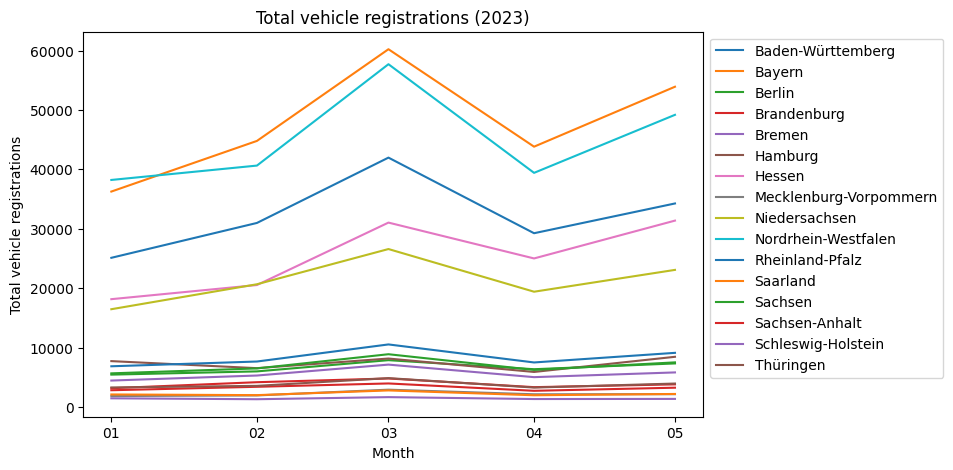

In [22]:
fig = plt.figure(figsize=(8,5))
sub = fig.add_subplot()

vr_state_month_df['month'] = pd.to_datetime(vr_state_month_df["month"], format="%m")
#x_ticks = range(1, vr_state_month_df['month'].max()+1)

for state in vr_state_month_df['federal_state'].unique():
    state_df = vr_state_month_df[vr_state_month_df['federal_state'] == state][['month', 'total']]
    
    sub.plot(state_df['month'], state_df['total'], label=state)

#sub.set_xticks(x_ticks)
sub.legend(bbox_to_anchor=(1,1),loc='upper left')
sub.xaxis.set_major_formatter(mdates.DateFormatter("%m"))
sub.xaxis.set_minor_formatter(mdates.DateFormatter("%m"))
sub.set_xticks(vr_state_month_df["month"].unique())
plt.ylabel("Total vehicle registrations")
plt.xlabel('Month')
plt.title(f'Total vehicle registrations ({year})')
plt.show()


## GDP of german federal states

In [16]:
with open("../data/federal_states.geo.json", encoding="utf-8") as geo_json:
    states = json.load(geo_json)
gdp_df = aggr_df[['federal_state', 'gdp_per_capita']]

fig = px.choropleth(gdp_df, geojson=states, locations='federal_state', color="gdp_per_capita",
                    scope="europe",
                    featureidkey="properties.name",
                    width=700, height=600,
                    title="German federal states",
                    labels={
                        'gdp_per_capita': "GDP per capita (in EUR)",
                        'federal_state': "Federal state",
                    })
fig.update_geos(visible=False, fitbounds='locations')

fig.show()

## Is there a correlation between share of EVs and GDP?
To answer our initial question, we use plotly to draw a scatterplot of all federal states, the x-axis representing the GDP and the y-axis showing the share of EVs among all vehicle reigstrations. The total number of EVs includes both purely electric and hybrid driven cars.

The states will be colored based on the total number of vehicle registrations, allowing us to see additionaly where the most vehicles are registered.  

To better visualize a potential correlation between share of VRs and GDP, a trendline is computed, using a linear regression based on the "ordinary least squares" method.
The trend line is displayed as an orange linear line.

In [17]:
aggr_df['share_electric'] = aggr_df['share_electric']*100
fig = px.scatter(aggr_df,
                 x='gdp_per_capita',
                 y='share_electric',
                 color='total',
                 hover_data=['federal_state'],
                 trendline='ols',
                 title=f"Correlation between share of EVs and GDP ({calendar.month_abbr[first_month]}-{calendar.month_abbr[last_month]} {year})",
                 labels={
                     'share_electric': "Share of EVs (in %)",
                     'gdp_per_capita': "GDP per capita (in EUR)",
                     'total': "Total # of VRs",
                     'federal_state': 'State'
                 }, width=800, height=600)


fig.show()


## Conclusion

The trend line shows a positive correlation between the share of EVs among all VRs and the states GDP, therefore it can be said that in states with a higher GDP there is a tendency to buy (and register) more EVs than cars with only a traditional combustion engine. One possible explanation for this could be the higher prices of EVs.